In [1]:
import os
import argparse
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from process_log import Tags, Log, Epochs, generate_fitness_wc_dataframe
from tqdm.notebook import tqdm
from plot_helper import create_barplot, create_speedup_plot
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
from plot_helper import remove_rank, calculate_wall_clock_time_thresholds, calculate_lengths_achieved

In [16]:
df = pd.read_csv("population_test_a280_Jan_05_194151.gz")
df

,fitness,wall clock time,epoch,rank,rep,population,elite_size,epochs,log_freq
0,11400,66.293,0,0,0,32,16,2670000,2670
1,9158,123.979,1,0,0,32,16,2670000,2670
2,8258,182.219,2,0,0,32,16,2670000,2670
3,7738,238.990,3,0,0,32,16,2670000,2670
4,7402,297.639,4,0,0,32,16,2670000,2670
...,...,...,...,...,...,...,...,...,...
159995,4277,74178.524,995,0,9,2048,1024,40000,40
159996,4277,74241.017,996,0,9,2048,1024,40000,40
159997,4277,74302.854,997,0,9,2048,1024,40000,40
159998,4277,74365.125,998,0,9,2048,1024,40000,40


In [19]:
len(df["population"].unique())

16

In [3]:
thresholds = calculate_wall_clock_time_thresholds(df)

In [6]:
line_df = calculate_lengths_achieved(df, thresholds)

In [74]:
df[df["fitness"] <= 3500].groupby(["rep"]).agg({"wall clock time" : "min"})["wall clock time"].median()

52074.9215

In [3]:
max_wct = df.groupby(["rep", "population", "elite_size", "epochs", "log_freq"]).agg({"wall clock time": "max"})["wall clock time"].min()
min_wct = df.groupby(["rep", "population", "elite_size", "epochs", "log_freq"]).agg({"wall clock time": "min"})["wall clock time"].max()
thresholds = np.round(np.linspace(min_wct, max_wct, num=100), 0).astype(int)
thresholds

array([  393,   918,  1443,  1968,  2493,  3018,  3543,  4068,  4593,
        5118,  5643,  6168,  6693,  7218,  7743,  8268,  8793,  9318,
        9843, 10368, 10893, 11418, 11943, 12468, 12993, 13518, 14043,
       14568, 15093, 15618, 16143, 16668, 17193, 17718, 18243, 18768,
       19293, 19818, 20343, 20868, 21393, 21918, 22443, 22968, 23493,
       24018, 24543, 25068, 25593, 26118, 26643, 27168, 27693, 28218,
       28743, 29268, 29793, 30318, 30843, 31368, 31893, 32418, 32943,
       33468, 33993, 34518, 35043, 35568, 36094, 36619, 37144, 37669,
       38194, 38719, 39244, 39769, 40294, 40819, 41344, 41869, 42394,
       42919, 43444, 43969, 44494, 45019, 45544, 46069, 46594, 47119,
       47644, 48169, 48694, 49219, 49744, 50269, 50794, 51319, 51844,
       52369])

In [4]:
line_df = None
for threshold in tqdm(thresholds):
    tmp_df = df[df["wall clock time"] >= threshold].groupby(["rep", "population", "elite_size", "epochs", "log_freq"]).agg({"fitness": "max"})
    tmp_df["wall clock time"] = threshold
    tmp_df = tmp_df.reset_index()

    if line_df is None:
        line_df = tmp_df
    else:
        line_df = line_df.append(tmp_df, ignore_index=True)
line_df

,rep,population,elite_size,epochs,log_freq,fitness,wall clock time
0,0,2,1,42750000,42750,24689,393
1,0,3,1,28500000,28500,21015,393
2,0,4,2,21380000,21380,8062,393
3,0,6,3,14250000,14250,6512,393
4,0,8,4,10690000,10690,7150,393
...,...,...,...,...,...,...,...
15994,9,1024,512,80000,80,3986,52369
15995,9,2048,1024,40000,40,4300,52369
15996,9,4096,2048,20000,20,4076,52369
15997,9,8192,4096,10000,10,3473,52369


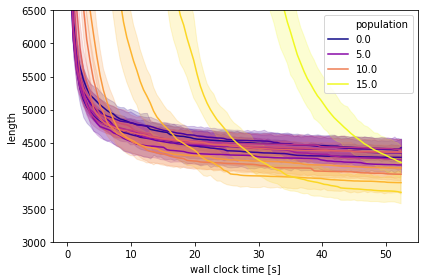

In [8]:
plot_df = line_df.copy()
plot_df["wall clock time"] = plot_df["wall clock time"] / 1000
plot_df["population"] = np.log2(plot_df["population"])

fig, ax = plt.subplots()
sns.lineplot(ax=ax, y="fitness", x="wall clock time", hue="population", data=plot_df, palette="plasma")
ax.set_ylim(3000, 6500)
ax.get_yaxis().set_label_text("length")
ax.get_xaxis().set_label_text("wall clock time [s]")
fig.savefig(f"population_test_a280.png", dpi=300)

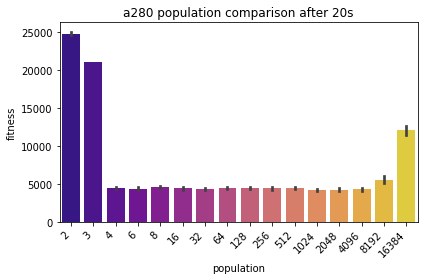

In [12]:
'''
Create a population scaling barplot from dataframe with predefined wall clock time thresholds
'''
def create_population_barplot(line_df, problem, palette="plasma", thresholds=None, population_thresholds=None):
    assert (thresholds is not None) or (population_thresholds is not None)
    
    # Figure out thresholds
    if thresholds is None:
        threshold_list = population_thresholds[problem]
    else:
        threshold_list = thresholds
        
    for threshold in tqdm(threshold_list):
        fig, ax = plt.subplots()
        sns.barplot(ax=ax, y="fitness", x="population", data=line_df[line_df["wall clock time"] == threshold], palette=palette)
        
        # Turn thresholds into seconds
        threshold_name = int(np.round(threshold / 1000, 0))
        
        # Make sure axis labels fit
        plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
        
        ax.set_title(f"{problem} population comparison after {threshold_name}s")
        fig.savefig(f"population_scaling_{problem}_{threshold_name}s.pdf")
    
create_population_barplot(line_df, "a280", population_thresholds={"a280" : [20343]})

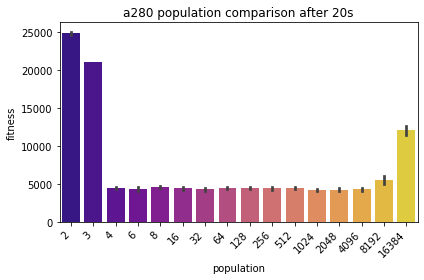

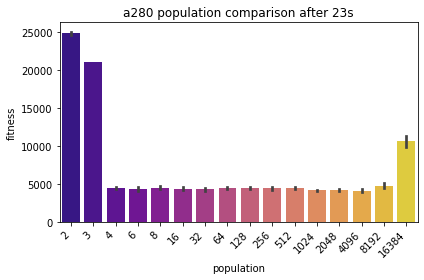

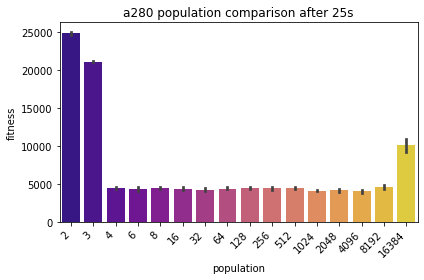

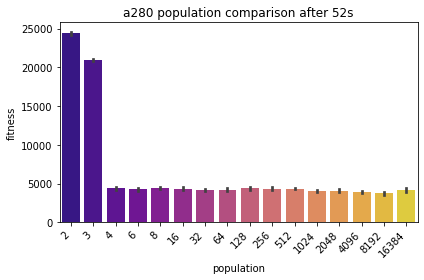

In [7]:
for threshold in [20343, 23493, 25068, 52369]:
    fig, ax = plt.subplots()
    sns.barplot(ax=ax, y="fitness", x="population", data=line_df[line_df["wall clock time"] == threshold], palette="plasma")
    threshold_name = int(np.round(threshold / 1000, 0))
    plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    ax.set_title(f"a280 population comparison after {threshold_name}s")
    fig.savefig(f"population_scaling_a280_{threshold_name}s.png", dpi=300)

In [44]:
df = pd.read_csv("population_test_d1291_Jan_06_001004.gz")
df

,fitness,wall clock time,epoch,rank,rep,population,elite_size,epochs,log_freq
0,1617109,950.414,0,0,0,8192,4096,10000,10
1,1604039,1840.544,1,0,0,8192,4096,10000,10
2,1585634,2704.421,2,0,0,8192,4096,10000,10
3,1569982,3641.255,3,0,0,8192,4096,10000,10
4,1561906,4600.385,4,0,0,8192,4096,10000,10
...,...,...,...,...,...,...,...,...,...
149995,176359,160505.543,995,0,9,256,128,180000,180
149996,176359,160637.867,996,0,9,256,128,180000,180
149997,176359,160770.702,997,0,9,256,128,180000,180
149998,176359,160905.558,998,0,9,256,128,180000,180


In [45]:
max_wct = df.groupby(["rep", "population", "elite_size", "epochs", "log_freq"]).agg({"wall clock time": "max"})["wall clock time"].min()
min_wct = df.groupby(["rep", "population", "elite_size", "epochs", "log_freq"]).agg({"wall clock time": "min"})["wall clock time"].max()
thresholds = np.round(np.linspace(min_wct, max_wct, num=100), 0).astype(int)
thresholds

array([  1071,   2273,   3474,   4675,   5876,   7078,   8279,   9480,
        10681,  11883,  13084,  14285,  15486,  16688,  17889,  19090,
        20291,  21493,  22694,  23895,  25096,  26298,  27499,  28700,
        29901,  31103,  32304,  33505,  34706,  35908,  37109,  38310,
        39511,  40713,  41914,  43115,  44316,  45517,  46719,  47920,
        49121,  50322,  51524,  52725,  53926,  55127,  56329,  57530,
        58731,  59932,  61134,  62335,  63536,  64737,  65939,  67140,
        68341,  69542,  70744,  71945,  73146,  74347,  75549,  76750,
        77951,  79152,  80354,  81555,  82756,  83957,  85159,  86360,
        87561,  88762,  89964,  91165,  92366,  93567,  94769,  95970,
        97171,  98372,  99574, 100775, 101976, 103177, 104379, 105580,
       106781, 107982, 109184, 110385, 111586, 112787, 113988, 115190,
       116391, 117592, 118793, 119995])

In [46]:
line_df = None
for threshold in tqdm(thresholds):
    tmp_df = df[df["wall clock time"] >= threshold].groupby(["rep", "population", "elite_size", "epochs", "log_freq"]).agg({"fitness": "max"})
    tmp_df["wall clock time"] = threshold
    tmp_df = tmp_df.reset_index()

    if line_df is None:
        line_df = tmp_df
    else:
        line_df = line_df.append(tmp_df, ignore_index=True)
line_df


,rep,population,elite_size,epochs,log_freq,fitness,wall clock time
0,0,2,1,22660000,22660,1244155,1071
1,0,3,1,15110000,15110,1072971,1071
2,0,4,2,11330000,11330,615252,1071
3,0,6,3,7550000,7550,593911,1071
4,0,8,4,5670000,5670,584562,1071
...,...,...,...,...,...,...,...
14994,9,512,256,90000,90,195928,119995
14995,9,1024,512,40000,40,220754,119995
14996,9,2048,1024,20000,20,274521,119995
14997,9,4096,2048,10000,10,426204,119995


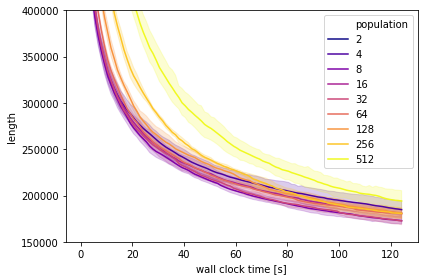

In [31]:
plot_df = line_df.copy()
plot_df["wall clock time"] = plot_df["wall clock time"] / 1000
plot_df["population"] = np.log2(plot_df["population"])

fig, ax = plt.subplots()
sns.lineplot(ax=ax, y="fitness", x="wall clock time", hue="population", data=plot_df, legend="full", palette="plasma")
ax.set_ylim(150000, 400000)

# Fix legend
for i, text in enumerate(ax.legend().texts):
    if i == 0:
        continue
    text.set_text(int(pow(2, float(text.get_text()))))
ax.get_yaxis().set_label_text("length")
ax.get_xaxis().set_label_text("wall clock time [s]")
fig.savefig(f"population_test_d1291.png", dpi=300)

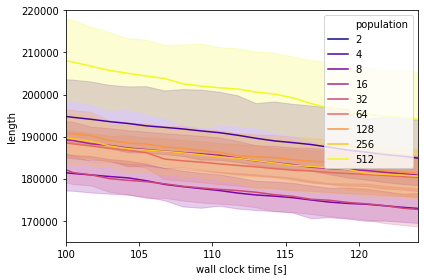

In [33]:
plot_df = line_df.copy()
plot_df["wall clock time"] = plot_df["wall clock time"] / 1000
plot_df["population"] = np.log2(plot_df["population"])

fig, ax = plt.subplots()
sns.lineplot(ax=ax, y="fitness", x="wall clock time", hue="population", data=plot_df, legend="full", palette="plasma")
ax.set_ylim(165000, 220000)
ax.set_xlim(100, 124)


# Fix legend
for i, text in enumerate(ax.legend().texts):
    if i == 0:
        continue
    text.set_text(int(pow(2, float(text.get_text()))))
ax.get_yaxis().set_label_text("length")
ax.get_xaxis().set_label_text("wall clock time [s]")
fig.savefig(f"population_test_d1291_zoom.png", dpi=300)

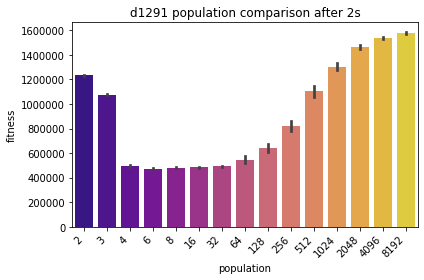

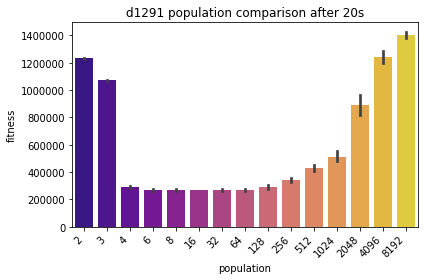

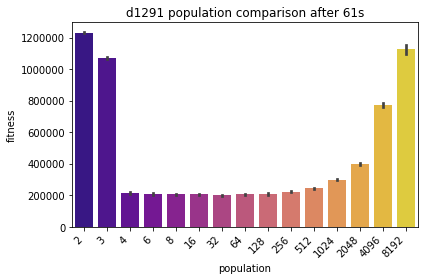

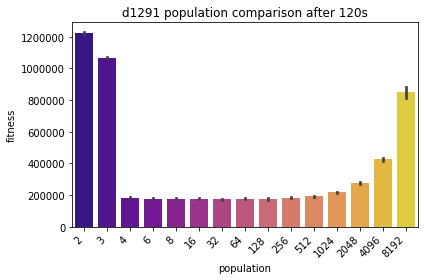

In [47]:
for threshold in [2273, 20291, 61134, 119995]:
    fig, ax = plt.subplots()
    sns.barplot(ax=ax, y="fitness", x="population", data=line_df[line_df["wall clock time"] == threshold], palette="plasma")
    threshold_name = int(np.round(threshold / 1000, 0))
    ax.set_title(f"d1291 population comparison after {threshold_name}s")
    plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    fig.savefig(f"population_scaling_d1291_{threshold_name}s.png", dpi=300)

In [13]:
df = pd.read_csv("population_test_u2319_Jan_06_081648.gz")
df = df[df["population"] < 2048]
df

,fitness,wall clock time,epoch,rank,rep,population,elite_size,epochs,log_freq
0,4989701,267.599,0,0,0,16,8,910000,910
1,4553019,505.886,1,0,0,16,8,910000,910
2,4206676,750.937,2,0,0,16,8,910000,910
3,3976105,1021.462,3,0,0,16,8,910000,910
4,3772582,1277.159,4,0,0,16,8,910000,910
...,...,...,...,...,...,...,...,...,...
119995,926858,165278.950,995,0,9,32,16,460000,460
119996,926218,165417.655,996,0,9,32,16,460000,460
119997,926167,165557.794,997,0,9,32,16,460000,460
119998,926167,165696.112,998,0,9,32,16,460000,460


In [14]:
df2 = pd.read_csv("population_test_u2319_Jan_06_162614.gz")
df = df.append(df2, ignore_index=True)
df

,fitness,wall clock time,epoch,rank,rep,population,elite_size,epochs,log_freq
0,4989701,267.599,0,0,0,16,8,910000,910
1,4553019,505.886,1,0,0,16,8,910000,910
2,4206676,750.937,2,0,0,16,8,910000,910
3,3976105,1021.462,3,0,0,16,8,910000,910
4,3772582,1277.159,4,0,0,16,8,910000,910
...,...,...,...,...,...,...,...,...,...
168905,4658904,260073.427,888,0,9,16384,8192,893,1
168906,4658904,260334.769,889,0,9,16384,8192,893,1
168907,4658904,260582.753,890,0,9,16384,8192,893,1
168908,4658904,260833.557,891,0,9,16384,8192,893,1


In [15]:
df.to_csv("population_test_u2319_final.gz", index=False)

In [50]:
max_wct = df.groupby(["rep", "population", "elite_size", "epochs", "log_freq"]).agg({"wall clock time": "max"})["wall clock time"].min()
min_wct = df.groupby(["rep", "population", "elite_size", "epochs", "log_freq"]).agg({"wall clock time": "min"})["wall clock time"].max()
thresholds = np.round(np.linspace(min_wct, max_wct, num=100), 0).astype(int)
thresholds

array([  1335,   2396,   3458,   4520,   5581,   6643,   7705,   8766,
         9828,  10890,  11951,  13013,  14075,  15136,  16198,  17259,
        18321,  19383,  20444,  21506,  22568,  23629,  24691,  25753,
        26814,  27876,  28938,  29999,  31061,  32122,  33184,  34246,
        35307,  36369,  37431,  38492,  39554,  40616,  41677,  42739,
        43801,  44862,  45924,  46985,  48047,  49109,  50170,  51232,
        52294,  53355,  54417,  55479,  56540,  57602,  58664,  59725,
        60787,  61849,  62910,  63972,  65033,  66095,  67157,  68218,
        69280,  70342,  71403,  72465,  73527,  74588,  75650,  76712,
        77773,  78835,  79896,  80958,  82020,  83081,  84143,  85205,
        86266,  87328,  88390,  89451,  90513,  91575,  92636,  93698,
        94759,  95821,  96883,  97944,  99006, 100068, 101129, 102191,
       103253, 104314, 105376, 106438])

In [51]:
line_df = None
for threshold in tqdm(thresholds):
    tmp_df = df[df["wall clock time"] >= threshold].groupby(["rep", "population", "elite_size", "epochs", "log_freq"]).agg({"fitness": "max"})
    tmp_df["wall clock time"] = threshold
    tmp_df = tmp_df.reset_index()

    if line_df is None:
        line_df = tmp_df
    else:
        line_df = line_df.append(tmp_df, ignore_index=True)
line_df

,rep,population,elite_size,epochs,log_freq,fitness,wall clock time
0,0,2,1,7320000,7320,4255768,1335
1,0,3,1,4880000,4880,3659322,1335
2,0,4,2,3660000,3660,3160855,1335
3,0,6,3,2440000,2440,3053241,1335
4,0,8,4,1830000,1830,3108589,1335
...,...,...,...,...,...,...,...
15994,9,1024,512,10000,10,1696414,106438
15995,9,2048,1024,7146,7,2612084,106438
15996,9,4096,2048,3573,3,3753753,106438
15997,9,8192,4096,1787,1,5025534,106438


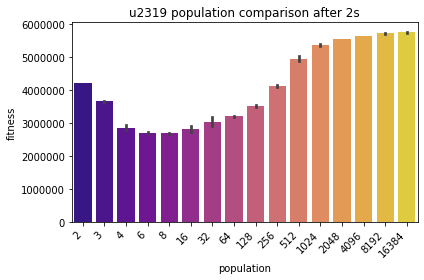

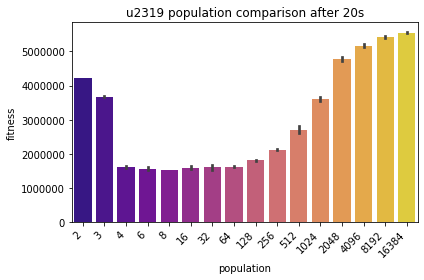

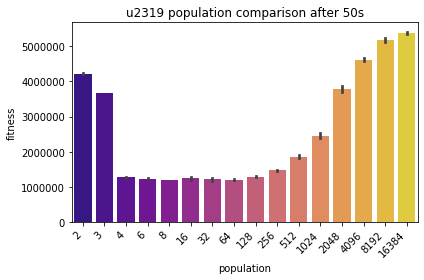

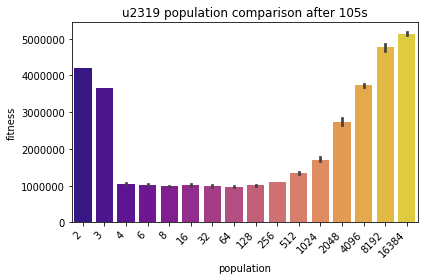

In [52]:
for threshold in [2396, 20444, 50170, 105376]:
    fig, ax = plt.subplots()
    sns.barplot(ax=ax, y="fitness", x="population", data=line_df[line_df["wall clock time"] == threshold], palette="plasma")
    threshold_name = int(np.round(threshold / 1000, 0))
    ax.set_title(f"u2319 population comparison after {threshold_name}s")
    plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    fig.savefig(f"population_scaling_u2319_{threshold_name}s.png", dpi=300)